# Enron E-mail dataset

This notebook anlyses the Enron email dataset, downloaded from: <br>
https://www.cs.cmu.edu/~./enron/
<br>
The dataset contains emails from Enron employees released as part of a US government investigation.
<br><br>
This notebook covers the following:
- Carry out an initial analysis of the dataset.
- Clean the dataset and remove any redundant data.
- Gain statistical insights from the data.

The insights section will focus on:
- basic anlysis of the email metadata (who sent what and when)
- clustering email text: can we use basic K-means clustering to identify groups of emails 
    - this can form the basis for labelling data for further anlysis
- topic analysis: can we extract topics for different groups of emails
    - this can be used to analyse what users are sending

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import glob
import os
import string
import time
from pathlib import Path

# import external packages
import sys
cwd = Path(os.getcwd())
sys.path.append(str(cwd.parent))
from data_utils.data_extraction import (
    get_metadata,
    get_email_body,
    strip_string,
    stem_text,
    remove_named_entities,
    extract_message_nouns
)
from data_utils.model_fitting import fit_tf_idf

In [2]:
# path to the dataset (set to correct path for the user)
data_path = Path("/Users/matthew/tmp/feedstock/maildir")

## Initial analysis
The aim of this section is to understand the dataset (e.g. what it contains, how the data is stored and formatted).

### Data storage
The dataset contains emails from 150 users. The username is used as a directory in the first layer of data storage.

In [3]:
users = [os.path.basename(u) for u in glob.glob(str(data_path / "*"))]
print(f"Number of users: {len(users)}")
print("")
print("10 random users:")
print("-" * len("10 random users:"))
print("\n".join(sorted(np.random.choice(users, 10))))

Number of users: 150

10 random users:
----------------
benson-r
crandell-s
lavorato-j
maggi-m
may-l
motley-m
saibi-e
sanders-r
stepenovitch-j
swerzbin-m


The emails are stored in the following format:<br><br>
*{user_name}/{email_folder}/{email_subfolder}/{email_name}*
<br><br>
- __email_folder__: the main folder the email is stored in, e.g. __inbox__, __sent__ etc.
- __email_subfolder__: there may be no sub-folder or more than 1.
- __email_name__: this is a number with a full-stop at the end, giving a count of emails in each folder/sub-folder (e.g. 1., 2. 3. etc.)
<br><br>

Below we store the location of each email in dataframe, using the following columns. Using this, we can read in any email by reconstructing the path to it for a given index value of the dataframe.
- __user__: user name of the email sender.
- __path__: path to the email from the email sender directory, which will be {email_folder}/{email_subfolder}
- __fname__: file name for the email, e.g. 1., 2., 3. etc.

In [4]:
df = pd.DataFrame(columns=["user", "path", "fname"])

for user in users:
    # email files end in .
    files = glob.glob(str(Path(data_path) / user / "**" / "*."), recursive=True)
    # find the filename
    fnames = [os.path.basename(f) for f in files]
    # find the path from data_path
    paths = [os.path.dirname(f) for f in files]
    paths = [p.split(f"{data_path}/{user}/")[-1] if p != f"{data_path}/{user}" else "" for p in paths]
    df_sub = pd.DataFrame(
        columns=["user", "path", "fname"],
        data=zip([user] * len(files), paths, fnames)
    )
    df = pd.concat([df, df_sub], axis=0)
df = df.sort_values(["user", "path", "fname"]).reset_index(drop=True)
display(df)

,user,path,fname
0,allen-p,_sent_mail,1.
1,allen-p,_sent_mail,10.
2,allen-p,_sent_mail,100.
3,allen-p,_sent_mail,1000.
4,allen-p,_sent_mail,1001.
...,...,...,...
517395,zufferli-j,sent_items,95.
517396,zufferli-j,sent_items,96.
517397,zufferli-j,sent_items,97.
517398,zufferli-j,sent_items,98.


### Overview of email senders
Of the 150 users, there are large differences in the number of emails sent/received.<br><br>

In [5]:
print(f"Total emails in dataset: {len(df)}")
print("")
print("-" * 50)
print("Emails per user (absolute values):")
vc = df["user"].value_counts()
display(vc.describe())
print(f"IQR:               {round(np.quantile(vc.values, 0.75) - np.quantile(vc.values, 0.25), 2)}")
print(f"Middle 95% range:  {round(np.quantile(vc.values, 0.975) - np.quantile(vc.values, 0.025), 2)}")
print("")

print("-" * 50)
print("Emails per user (percentage values):")
vc = df["user"].value_counts() * 100.0 / len(df)
display(vc.describe())

print("-" * 50)
print("Users responsible for most emails (as a %):")
display(vc.head())

Total emails in dataset: 517400

--------------------------------------------------
Emails per user (absolute values):


count      150.000000
mean      3449.333333
std       5018.575376
min         35.000000
25%        955.750000
50%       1652.000000
75%       3399.500000
max      28465.000000
Name: user, dtype: float64

IQR:               2443.75
Middle 95% range:  20565.75

--------------------------------------------------
Emails per user (percentage values):


count    150.000000
mean       0.666667
std        0.969960
min        0.006765
25%        0.184722
50%        0.319289
75%        0.657035
max        5.501546
Name: user, dtype: float64

--------------------------------------------------
Users responsible for most emails (as a %):


kaminski-v    5.501546
dasovich-j    5.456900
kean-s        4.899691
mann-k        4.518941
jones-t       3.855818
Name: user, dtype: float64

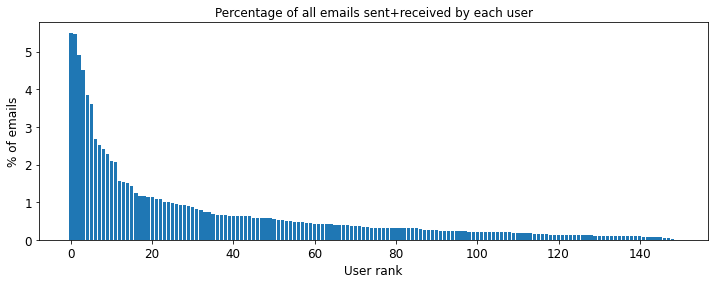

In [6]:
plt.figure(figsize=(12, 4))
plt.bar(range(len(vc)), vc.values)
plt.title("Percentage of all emails sent+received by each user", fontsize=12)
plt.ylabel("% of emails", fontsize=12)
plt.xlabel("User rank", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Email storage
- Most emails are stored in default folders (e.g. all_documents, inbox, sent).
- Many folders have a single email in them.
- Some non-default folder names have many emails e.g. bill_williams_iii.

- all_documents needs to be checked that it does not duplicate other folders.
- Some folders can be identified as sent or received, others are not so clear.

In [7]:
vc = df["path"].value_counts()
print(f"Number of unique folders (including sub-folders): {len(vc)}")
print("")
print("Number of emails in each folder:")
display(vc.head(20))
display(vc.tail(20))

Number of unique folders (including sub-folders): 1940

Number of emails in each folder:


all_documents                            128103
discussion_threads                        58609
sent                                      57653
deleted_items                             50991
inbox                                     41508
sent_items                                37920
notes_inbox                               36665
_sent_mail                                30109
calendar/untitled                          4478
archiving/untitled                         4477
personal                                   2420
attachments                                2026
meetings                                   1872
calendar                                   1655
schedule_crawler                           1398
logistics                                  1192
tw_commercial_group                        1159
california                                 1052
bill_williams_iii                          1022
deal_communication/deal_discrepancies       897
Name: path, dtype: int64

argentina___phone_list           1
inbox/eesiresponsesrfp           1
arizona                          1
gas_deals                        1
investing                        1
roseman_creek                    1
ercot/origination                1
edson                            1
computer                         1
temporary_export_certificates    1
water                            1
disclosure_rules                 1
puhca                            1
pba_s                            1
ercot/pricing                    1
icap_policy                      1
western_governor_s_university    1
deleted_items/ljm                1
inbox/terminations               1
planning                         1
Name: path, dtype: int64

In [8]:
# potential folders for sent emails
sent_folders = sorted(
    [v for v in vc.index if ("present" not in v.lower()) and ("sent" in v.lower()) or ("outb" in v.lower())]
)
n_sent = vc[sent_folders].sum()
n_rec = vc[~vc.index.isin(sent_folders)].sum()
n_tot = vc.sum()
print(f"Number of sent emails:     {n_sent} ({round(100.0 * n_sent / n_tot)}%)")
print(f"Number or received emails: {n_rec} ({round(100.0 * n_rec / n_tot)}%)")
print("")
print("\n".join(sent_folders))

Number of sent emails:     126772 (25%)
Number or received emails: 390628 (75%)

_sent
_sent_mail
chris_stokley/sent
deleted_items/_sent_mail
diana_scholtes/saved_sent
hold/old_sent
outbox
outbox/personal
outbox/personal/untitled
sent
sent_items
sent_items/clickathome


### Extracting email meta-data
The metadata for the emails is stored at the top of the email text. The format is:
<br><br>
metadata_key_1: metadata_value_1<br>
metadata_key_2: metadata_value_2<br>
...<br>
...<br>
metadata_key_N: metadata_value_N<br>
<br><br>
These are extracted from the email body and stored in a dataframe:
- columns: metadata keys
- index: email index, as in df
- values: the metadata values

#### Metadate columns

The metadata has the following columns (with our data for user, path and fname added).

- __Message-ID__: Unique id for the email.
- __Mime-Version__: Stands for "Multipurpose Internet Mail Extension"
- __Date__: Date that the email was sent, with timezone.
- __From__: Sender of the email, not necessarily the same
- __To__: Receiver of the email.
- __Subject__: Subject line of the email.
- __Content-Type__: Encoding of the email body text.
- __Content-Transfer-Encoding__: Mechanism for re-encoding data for sending the email.
- __X-From__: Name of the sender (with email address if external)
- __X-To__: Name of the recipient, with email address in some cases (mostly external)
- __X-cc__: List of CC'd recipients.
- __X-bcc__: List of BCC'd recipients.
- __X-Folder__: Storage folder of the email.
- __X-Origin__: Origin of the email, not necessarily the same as the user, could be due to errors in storing the emails.
- __X-FileName__: Notes Storage Facility filename (used by IBM Notes to store email data).
- __Cc__: List of CC'd recipients, sometimes different from X-cc.
- __Bcc__: List of BCC'd recipients, seems to be the same as CC.
- __user__: Username, from the folder the emails are stored in.
- __path__: Path the email is stored in, from the user folder (e.g. username/path/1.)
- __fname__: Filename of the email, stored as 1., 2., 3.

In [9]:
# read in all the metadata, using get_metadata function

start_time = time.time()

contents_meta_all = {}

# extract metadata for a sample of N emails (use all or a sub-sample)
# Note: it can take ~30mins to read in all the metadata (for ~500,000 emails)
N = len(df)
if N < len(df):
    inds = sorted(np.random.choice(range(len(df)), N, replace=False))
else:
    inds = list(df.index)

for i, ind in enumerate(inds):
    fname = os.path.join(data_path, "/".join(df.loc[ind, ["user", "path", "fname"]].values))
    with open(fname, "r", errors='replace') as f:
        contents = f.readlines()
        try:
            contents_meta = get_metadata(contents)
        except ValueError:
            print(f"{i}: No meta data for {fname}")
            contents_meta = {}
        contents_meta_all[ind] = contents_meta
    if np.remainder((i + 1), int(N / 100)) == 0:
        print(f"complete: {round(100.0 * (i + 1) / N, 2)}% in {round(time.time() - start_time, 2)}s")
df_meta = pd.DataFrame.from_dict(contents_meta_all, orient="index")
print(time.time() - start_time)
display(df_meta.sample(n=20))
# cleanup
del contents_meta_all

complete: 1.0% in 15.48s
complete: 2.0% in 32.19s
complete: 3.0% in 53.01s
complete: 4.0% in 69.63s
complete: 5.0% in 86.57s
complete: 6.0% in 106.25s
complete: 7.0% in 122.95s
complete: 8.0% in 139.05s
complete: 9.0% in 156.01s
complete: 10.0% in 172.35s
complete: 11.0% in 191.01s
complete: 12.0% in 212.34s
complete: 13.0% in 229.89s
complete: 14.0% in 248.38s
complete: 15.0% in 269.08s
complete: 16.0% in 287.31s
complete: 17.0% in 304.16s
complete: 18.0% in 320.88s
complete: 19.0% in 337.73s
complete: 20.0% in 377.59s
complete: 21.0% in 448.27s
complete: 22.0% in 479.58s
complete: 23.0% in 509.9s
complete: 24.0% in 539.13s
complete: 25.0% in 568.02s
complete: 26.0% in 590.91s
complete: 27.0% in 615.38s
complete: 28.0% in 640.51s
complete: 29.0% in 658.3s
complete: 30.0% in 675.55s
complete: 31.0% in 693.98s
complete: 32.0% in 711.36s
complete: 33.0% in 727.98s
complete: 34.0% in 745.07s
complete: 35.0% in 761.45s
complete: 36.0% in 779.15s
complete: 37.0% in 795.3s
complete: 38.0% in

,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Cc,Bcc
507361,<25587350.1075861997026.JavaMail.evans@thyme>,"Tue, 6 Nov 2001 12:41:07 -0800 (PST)",kathy@coga.org,"vessels.tom@enron.com, stornetta.todd@enron.co...",Reception for COGA Annual Meeting Keynote Bill...,1.0,text/plain; charset=us-ascii,7bit,Kathy Drew <kathy@coga.org>,"Tom Vessels <tvessels@aol.com>, Todd Stornetta...",,,"\MWHITT (Non-Privileged)\Whitt, Mark\Inbox",Whitt-M,MWHITT (Non-Privileged).pst,NaN,NaN
37792,<22568564.1075858308392.JavaMail.evans@thyme>,"Mon, 5 Feb 2001 07:32:00 -0800 (PST)",rick.buy@enron.com,ted.murphy@enron.com,RBB Visit to London,1.0,text/plain; charset=us-ascii,7bit,Rick Buy,Ted Murphy,,,\Richard_Buy_Jun2001\Notes Folders\All documents,Buy-R,rbuy.nsf,NaN,NaN
286066,<4161810.1075844050614.JavaMail.evans@thyme>,"Thu, 16 Nov 2000 08:02:00 -0800 (PST)",lorna.brennan@enron.com,"rockey.storie@enron.com, kent.miller@enron.com...",Midmonth Report: Early Warning - CERA Alert,1.0,text/plain; charset=us-ascii,7bit,Lorna Brennan,"Rockey Storie, Kent Miller, John Dushinske, Da...",,,\Michelle_Lokay_Dec2000_June2001_1\Notes Folde...,LOKAY-M,mlokay.nsf,NaN,NaN
355110,<5751361.1075863216184.JavaMail.evans@thyme>,"Wed, 14 Nov 2001 12:19:08 -0800 (PST)",stephanie.panus@enron.com,mark.greenberg@enron.com,FW: Beta Agreement with 3PARdata,1.0,text/plain; charset=us-ascii,7bit,"Panus, Stephanie </O=ENRON/OU=NA/CN=RECIPIENTS...","Greenberg, Mark </O=ENRON/OU=NA/CN=RECIPIENTS/...",,,"\SPANUS (Non-Privileged)\Panus, Stephanie\Dele...",Panus-S,SPANUS (Non-Privileged).pst,NaN,NaN
213435,<18628328.1075855456945.JavaMail.evans@thyme>,"Tue, 25 Dec 2001 15:10:15 -0800 (PST)",ind@websystems.com,j.kaminski@enron.com,Industrial Website,1.0,text/plain; charset=us-ascii,7bit,Ind@websystems.com (For your Info)@ENRON,"Kaminski, Vince J </O=ENRON/OU=NA/CN=RECIPIENT...",,,"\Vincent_Kaminski_Jan2002_1\Kaminski, Vince J\...",Kaminski-V,vkamins (Non-Privileged).pst,NaN,NaN
416201,<13883564.1075844402407.JavaMail.evans@thyme>,"Mon, 18 Sep 2000 11:05:00 -0700 (PDT)",tana.jones@enron.com,jpeters@andrews-kurth.com,"Re: ""Other Agreements"" in Lotus Notes",1.0,text/plain; charset=us-ascii,7bit,Tana Jones,jpeters@andrews-kurth.com,Sara Shackleton,,\Sara_Shackleton_Dec2000_June2001_1\Notes Fold...,SHACKLETON-S,sshackle.nsf,sara.shackleton@enron.com,sara.shackleton@enron.com
11931,<7108457.1075854616444.JavaMail.evans@thyme>,"Thu, 2 Mar 2000 05:24:00 -0800 (PST)",eric.bass@enron.com,tobin.carlson@enron.com,New Book,1.0,text/plain; charset=us-ascii,7bit,Eric Bass,Tobin Carlson,,,\Eric_Bass_Dec2000\Notes Folders\All documents,Bass-E,ebass.nsf,NaN,NaN
25190,<2140742.1075855818552.JavaMail.evans@thyme>,"Fri, 10 Mar 2000 07:27:00 -0800 (PST)",lisa.cousino@enron.com,"sally.beck@enron.com, leslie.reeves@enron.com,...",Floor Space Planning - Staff Meeting Item for ...,1.0,text/plain; charset=us-ascii,7bit,Lisa B Cousino,"Sally Beck, Leslie Reeves, Robert Superty, Bre...",Patti Thompson,,"\Sally_Beck_Dec2000\Notes Folders\Cousino, lisa",Beck-S,sbeck.nsf,patti.thompson@enron.com,patti.thompson@enron.com
400093,<3316214.1075840026813.JavaMail.evans@thyme>,"Wed, 31 Oct 2001 17:46:09 -0800 (PST)",diana.scholtes@enron.com,bill_casey@pgn.com,FW: Happy Halloween 8)~,1.0,text/plain; charset=us-ascii,7bit,"Scholtes, Diana </O=ENRON/OU=NA/CN=RECIPIENTS/...",'bill_casey@pgn.com',,,"\ExMerge - Scholtes, Diana\Sent Items",SCHOLTES-D,,NaN,NaN
451298,<19140889.1075842096057.JavaMail.evans@thyme>,"Thu, 1 Jun 2000 11:27:00 -0700 (PDT)",carol.clair@enron.com,steven.kessler@db.com,Re: Credit Comments,1.0,text/plain; charset=us-ascii,7bit,Carol St Clair,steven.kessler@db.com@ENRON,,,\Carol_StClair_Dec2000_1\Notes Folders\All doc...,STCLAIR-C,cstclai.nsf,NaN,NaN


Make sure no rows are duplicated

In [10]:
print(f"Number of duplicated rows: {df_meta.duplicated().sum()}")

Number of duplicated rows: 0


We now check for redundant columns. That is, those where all values are the same, or that duplicate other columns)

In [11]:
# check for redundant columns

# - Message-ID we can drop, each is unique and we use the integer index as a unique ID
# - Mime-Version (Multipurpose Internet Mail Extensions) is always the same
# - X-bcc has a less than 1% non-empty values
print("column name".ljust(30), "num. unique vals".ljust(25), "% unique vals")
for col in df_meta.columns:
    print(
        col.ljust(30),
        str(len(df_meta[col].unique())).ljust(25),
        round(100.0 * len(df_meta[col].unique()) / len(df_meta), 4))

print("\n")
print("Columns with few unique values:")
for col in [col for col in df_meta.columns if len(df_meta[col].unique()) < 10]:
    print("\n")
    print("-" * 50)
    print(col)
    display(df_meta[col].value_counts())
    

column name                    num. unique vals          % unique vals
Message-ID                     517400                    100.0
Date                           224127                    43.3179
From                           20328                     3.9289
To                             58564                     11.3189
Subject                        159280                    30.7847
Mime-Version                   1                         0.0002
Content-Type                   2                         0.0004
Content-Transfer-Encoding      3                         0.0006
X-From                         27985                     5.4088
X-To                           73532                     14.2118
X-cc                           33701                     6.5135
X-bcc                          132                       0.0255
X-Folder                       5335                      1.0311
X-Origin                       259                       0.0501
X-FileName                    

1.0    517400
Name: Mime-Version, dtype: int64



--------------------------------------------------
Content-Type


text/plain; charset=us-ascii          479309
text/plain; charset=ANSI_X3.4-1968     38091
Name: Content-Type, dtype: int64



--------------------------------------------------
Content-Transfer-Encoding


7bit                494997
quoted-printable     22399
base64                   4
Name: Content-Transfer-Encoding, dtype: int64

#### Missing data
Some columns have missing data. In some cases, metadata was not present for an email (Cc, Bcc). In other cases, the key was present, but there is value, and it is stored here as an empty string.

In [12]:
# To is missing for some emails
# Cc and Bcc have missing values, and seem to be the same overall
display(df_meta.loc[:, df_meta.isnull().sum(axis=0) != 0].isnull().sum(axis=0))

# Bcc and Cc both missing is the same as when either is missing
print(f"Num where Bcc and Cc are both NaN:    {df_meta[['Cc', 'Bcc']].isnull().all(axis=1).sum()}")
# Bcc and Cc not missing, have the same value 100% of the time
inds = df_meta[['Cc', 'Bcc']].notnull().all(axis=1)
print(f"% of entries where Bcc = Cc != NaN:   {100.0 * (df_meta.loc[inds, 'Cc'] == df_meta.loc[inds, 'Bcc']).mean()}%")

# This means that we can drop Bcc, since it is the same as Cc

To      21846
Cc     389519
Bcc    389519
dtype: int64

Num where Bcc and Cc are both NaN:    389519
% of entries where Bcc = Cc != NaN:   100.0%


In [13]:
# drop columns we don't need
# - Bcc is the same as Cc
# - Message-ID is not needed, we use the dataframe index as the id
# - Mime-Version is the same for all emails
df_meta = df_meta.drop(["Bcc", "Message-ID", "Mime-Version"], axis=1)

In [14]:
# merge with the user/path info
df_meta = df_meta.merge(df, left_index=True, right_index=True, how="left")
del df

In [15]:
# save the data (set to True)
if False:
    df_meta.to_csv(str(data_path.parent / "meta.csv"))

### Email time / date
The time and date that the email was sent, including the timezone, is stored in the metadata.
<br>
No values are missing. We can parse these, and explore when emails are sent/received.

In [16]:
# timezones (probably just tell us time of year)
df_meta["Date"].str.replace(r'[^(]*\(|\)[^)]*', '').value_counts()

PDT    269084
PST    248316
Name: Date, dtype: int64

In [17]:
# convert to a datetime, using UTC (since the dates are timezone aware)
df_meta["datetime_utc"] = pd.to_datetime(df_meta["Date"], utc=True)

In [18]:
# First look at the year:

# Most data is from 2000 - 2001
# 1999 and 2002 also have data

# Some are clearly incorrect (e.g. 1980, 2043)

print("value counts for years")
display(df_meta["datetime_utc"].dt.year.value_counts())

value counts for years


2001    272963
2000    196100
2002     35974
1999     11144
1980       522
1997       437
1998       177
2004        70
2044         3
2020         2
2012         2
1986         2
2043         1
2024         1
2007         1
2005         1
Name: datetime_utc, dtype: int64

In [19]:
# 1997 and 1998 could be actual emails

# 1997: most emails are from 1 user 
display(df_meta.loc[df_meta["datetime_utc"].dt.year == 1997, "user"].value_counts())
# 1998: most emails are from 1 user 
display(df_meta.loc[df_meta["datetime_utc"].dt.year == 1998, "user"].value_counts())

kean-s    436
love-p      1
Name: user, dtype: int64

taylor-m      170
skilling-j      3
dasovich-j      2
thomas-p        1
hain-m          1
Name: user, dtype: int64

In [20]:
# some have a date of 1980: all same time, must be an error / placeholder valaue
df_meta[df_meta["datetime_utc"].dt.year == 1980]

,Date,From,To,Subject,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Cc,user,path,fname,datetime_utc
664,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",phillip.allen@enron.com,muller@thedoghousemail.com,Re: (No Subject),text/plain; charset=us-ascii,7bit,Phillip K Allen,muller@thedoghousemail.com,,,\Phillip_Allen_Dec2000\Notes Folders\All docum...,Allen-P,pallen.nsf,NaN,allen-p,all_documents,157.,1980-01-01 00:00:00+00:00
698,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",phillip.allen@enron.com,"stephen.harrington@enron.com, mary@enron.com",,text/plain; charset=us-ascii,7bit,Phillip K Allen,"Stephen Harrington, Mary",,,\Phillip_Allen_Dec2000\Notes Folders\All docum...,Allen-P,pallen.nsf,NaN,allen-p,all_documents,188.,1980-01-01 00:00:00+00:00
715,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",phillip.allen@enron.com,jsmith@austintx.com,Re: MISSION SOUTH,text/plain; charset=us-ascii,7bit,Phillip K Allen,"""Jeff Smith"" <jsmith@austintx.com> @ ENRON",,,\Phillip_Allen_Dec2000\Notes Folders\All docum...,Allen-P,pallen.nsf,NaN,allen-p,all_documents,202.,1980-01-01 00:00:00+00:00
716,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",phillip.allen@enron.com,"john.lavorato@enron.com, beth.perlman@enron.co...",systems wish list,text/plain; charset=us-ascii,7bit,Phillip K Allen,"John J Lavorato, Beth Perlman, Hunter S Shivel...",,,\Phillip_Allen_Dec2000\Notes Folders\All docum...,Allen-P,pallen.nsf,NaN,allen-p,all_documents,203.,1980-01-01 00:00:00+00:00
842,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",phillip.allen@enron.com,maryrichards7@hotmail.com,Re:,text/plain; charset=us-ascii,7bit,Phillip K Allen,"""mary richards"" <maryrichards7@hotmail.com> @ ...",,,\Phillip_Allen_Dec2000\Notes Folders\All docum...,Allen-P,pallen.nsf,NaN,allen-p,all_documents,319.,1980-01-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508498,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",jason.williams@enron.com,"edward.sacks@enron.com, tracy.ngo@enron.com",Praxair,text/plain; charset=us-ascii,7bit,Jason R Williams,"Edward Sacks, Tracy Ngo",,,\Jason_Williams_Nov2001\Notes Folders\Discussi...,WILLIAMS-J,jwilli10.nsf,NaN,williams-j,discussion_threads,69.,1980-01-01 00:00:00+00:00
508503,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",jason.williams@enron.com,thedolan@yahoo.com,Re: Bliss,text/plain; charset=us-ascii,7bit,Jason R Williams,Andy Doran <thedolan@yahoo.com>,,,\Jason_Williams_Nov2001\Notes Folders\Discussi...,WILLIAMS-J,jwilli10.nsf,NaN,williams-j,discussion_threads,73.,1980-01-01 00:00:00+00:00
508504,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",jason.williams@enron.com,"susan.bailey@enron.com, samantha.boyd@enron.co...","Praxair, Inc.",text/plain; charset=us-ascii,7bit,Jason R Williams,"Susan Bailey, Samantha Boyd, Stephanie Panus",,,\Jason_Williams_Nov2001\Notes Folders\Discussi...,WILLIAMS-J,jwilli10.nsf,NaN,williams-j,discussion_threads,74.,1980-01-01 00:00:00+00:00
508508,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",jason.williams@enron.com,derek.bailey@enron.com,Johns Manville,text/plain; charset=us-ascii,7bit,Jason R Williams,Derek Bailey,,,\Jason_Williams_Nov2001\Notes Folders\Discussi...,WILLIAMS-J,jwilli10.nsf,NaN,williams-j,discussion_threads,78.,1980-01-01 00:00:00+00:00


In [21]:
# look at years that do not occur a lot: these seem to be spam (from none Enron email addresses)
# also all are outlier years from the data
# probably have data for 1997 to 2002

vc = df_meta["datetime_utc"].dt.year.value_counts()
for year in vc[vc.values < 100].index:
    print("")
    print("-" * 50)
    print(year)
    data = df_meta[df_meta["datetime_utc"].dt.year == year]
    display(data["From"].value_counts())


--------------------------------------------------
2004


hotwebcash@lists.adversend.com           40
football@cnnsi.com                        4
consumercare@autobytel.com                2
mvaughan@forrester.com                    2
customerservice@autobytel.com             2
survey@autobytel.com                      2
1800flowers.237779293@s2u2.com            1
1800flowers.224433405@s2u2.com            1
trnews@tr.com                             1
1800flowers.199693074@s2u2.com            1
1800flowers.243967005@s2u2.com            1
1800flowers.215430146@s2u2.com            1
1800flowers.213067706@s2u2.com            1
1800flowers.199693062@s2u2.com            1
1800flowers.238953664@s2u2.com            1
noreply@cnnimail9.cnn.com                 1
1800flowers.215124894@s2u2.com            1
clientservices@anntaylor.com              1
1800flowers.195367247@s2u2.com            1
1800flowers.200573461@s2u2.com            1
domestications.198273363@s2u2.com         1
announcement@popularlink.com              1
1800flowers.238953685@s2u2.com  


--------------------------------------------------
2044


cramer@cadvision.com    3
Name: From, dtype: int64


--------------------------------------------------
2020


jody421@hotmail.com    2
Name: From, dtype: int64


--------------------------------------------------
2012


dvdnow_52772@xoip.com    1
dvdnow_77395@xoip.com    1
Name: From, dtype: int64


--------------------------------------------------
1986


znflajg@aol.com     1
zsxgcgrl@aol.com    1
Name: From, dtype: int64


--------------------------------------------------
2043


cramer@cadvision.com    1
Name: From, dtype: int64


--------------------------------------------------
2024


pse6yl706@aloha.net    1
Name: From, dtype: int64


--------------------------------------------------
2007


rwalker802@earthlink.net    1
Name: From, dtype: int64


--------------------------------------------------
2005


johansc2924@picko.tandoori.demon.co.uk    1
Name: From, dtype: int64

In [22]:
# have to remove 1980s and the other years where the counts are low for any analysis on years
years = list(vc[vc.values < 100].index) + [1980]


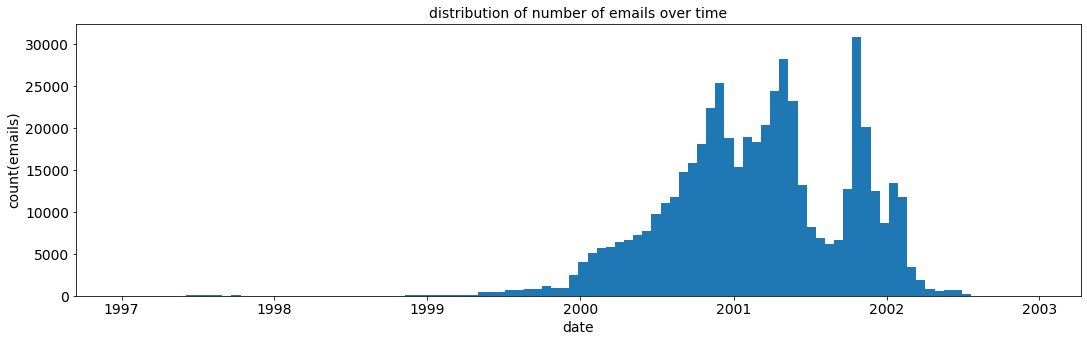

In [23]:
# distribution of emails by time
plt.figure(figsize=(18, 5))
plt.hist(df_meta.loc[~df_meta["datetime_utc"].dt.year.isin(years), "datetime_utc"], bins=100)
plt.title("distribution of number of emails over time", fontsize=14)
plt.xlabel("date", fontsize=14)
plt.ylabel("count(emails)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Value counts for dates:


2000-12-13    3452
2000-12-12    3053
2001-10-26    2943
2001-10-25    2796
2001-11-19    2724
              ... 
2002-12-21       1
1999-09-26       1
2002-10-09       1
1999-05-16       1
1997-01-01       1
Name: datetime_utc, Length: 1331, dtype: int64

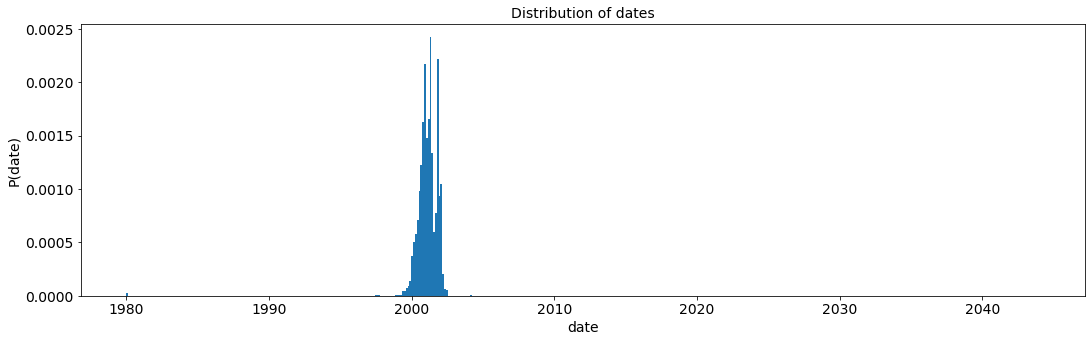

In [24]:
# next look at basic date

# Large variation, some days with several 1000, some with 1

print("Value counts for dates:")
vc = df_meta.loc[~df_meta["datetime_utc"].dt.year.isin(years), "datetime_utc"].dt.date.value_counts()
display(vc)

plt.figure(figsize=(18, 5))
plt.hist(df_meta.loc[~df_meta["datetime_utc"].dt.year.isin(years), "datetime_utc"].dt.date, bins=500, density=1.0)
plt.title("Distribution of dates", fontsize=14)
plt.xlabel("date", fontsize=14)
plt.ylabel("P(date)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

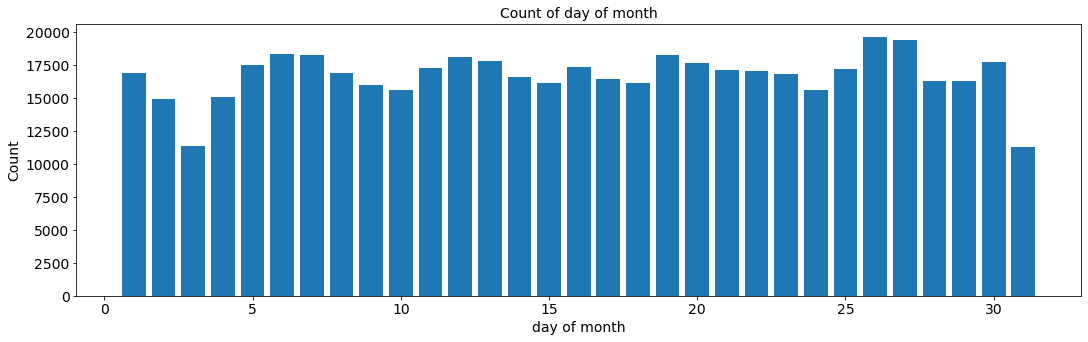

In [25]:
# day of the month is fairly constant (less months have 31 days)
vc = df_meta.loc[~df_meta["datetime_utc"].dt.year.isin(years), "datetime_utc"].dt.day.value_counts()

plt.figure(figsize=(18, 5))
plt.bar(vc.index, vc.values)
plt.title("Count of day of month", fontsize=14)
plt.xlabel("day of month", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

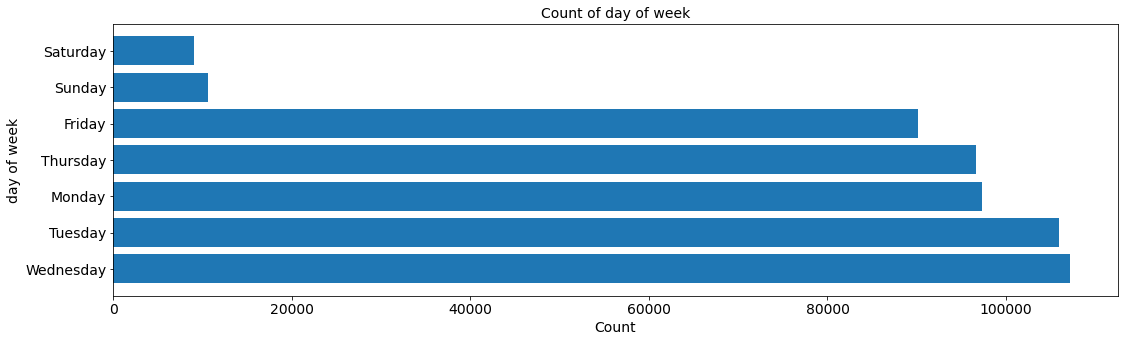

In [26]:
# Weekends have less emails sent and received
# Mid-week has most

vc = df_meta.loc[~df_meta["datetime_utc"].dt.year.isin(years), "datetime_utc"].dt.day_name().value_counts()
plt.figure(figsize=(18, 5))
plt.barh(vc.index, vc.values)
plt.title("Count of day of week", fontsize=14)
plt.ylabel("day of week", fontsize=14)
plt.xlabel("Count", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

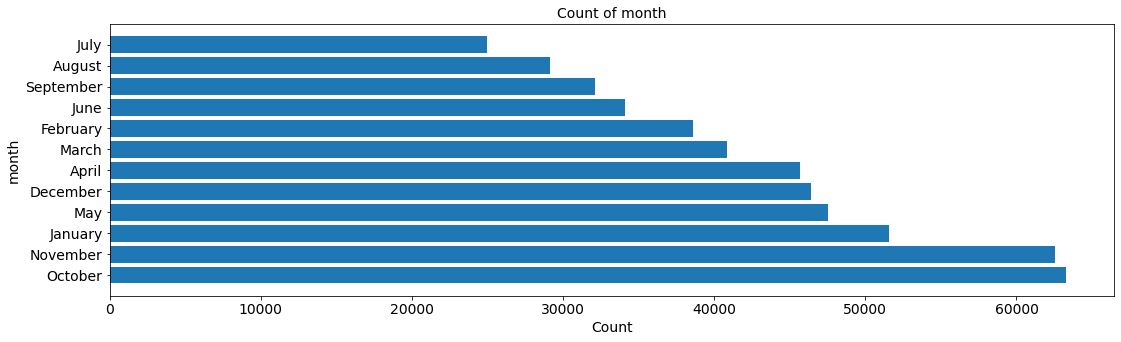

In [27]:
# The summer months produce less emails
# Autumn produces the most (catch up after summer?)

vc = df_meta.loc[~df_meta["datetime_utc"].dt.year.isin(years), "datetime_utc"].dt.month_name().value_counts()

plt.figure(figsize=(18, 5))
plt.barh(vc.index, vc.values)
plt.title("Count of month", fontsize=14)
plt.ylabel("month", fontsize=14)
plt.xlabel("Count", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [28]:
# email rates: how many emails each user sends/receives per day

tmp = (
    df_meta.loc[~df_meta["datetime_utc"].dt.year.isin(years), :]
    .groupby("user")["datetime_utc"].agg(["count", "min", "max"])
)
tmp["range"] = (tmp["max"] - tmp["min"]).dt.days
tmp["email_rate"] = tmp["count"] / tmp["range"]

In [29]:
display(tmp.sort_values(["email_rate", "count", "range"]))

,count,min,max,range,email_rate
user,,,,,
phanis-s,35,2001-06-22 19:16:02+00:00,2001-12-31 22:34:49+00:00,192,0.182292
slinger-r,132,2001-04-19 22:56:00+00:00,2002-02-07 01:16:30+00:00,293,0.450512
bailey-s,478,2000-04-19 16:53:00+00:00,2002-03-21 18:48:12+00:00,701,0.681883
south-s,248,2000-06-09 14:45:00+00:00,2001-06-01 17:23:00+00:00,357,0.694678
harris-s,548,2000-02-09 23:10:28+00:00,2002-01-01 19:22:52+00:00,691,0.793054
...,...,...,...,...,...
mann-k,23343,2000-06-02 13:05:00+00:00,2002-05-09 14:23:00+00:00,706,33.063739
merriss-s,1627,2001-03-12 23:16:00+00:00,2001-05-01 16:30:00+00:00,49,33.204082
kaminski-v,28439,1999-11-30 11:22:00+00:00,2002-02-04 01:07:04+00:00,796,35.727387


In [30]:
# "linder-e" has the highest email rate: 2805 in 49 days. Some seem to be repeated
display(df_meta.loc[df_meta["user"] == "linder-e", "Subject"].value_counts())
print("-" * 80)
# "symes-k" is similar
display(df_meta.loc[df_meta["user"] == "symes-k", "Subject"].value_counts())

Schedule Crawler: HourAhead Failure <CODESITE>           330
RE: Reply Requested: Do You Code Or Approve Invoices?     34
                                                           9
Re: New Hire Dinner invitations...                         9
SAP SYSTEM OUTAGE NOTIFICATIONS                            9
                                                        ... 
Mail List Removal                                          2
TIMEKEEPING ENTRY DEADLINE REMINDER                        2
Re: APS losses                                             2
TIMEKEEPING REMINDER                                       1
is this you?                                               1
Name: Subject, Length: 805, dtype: int64

--------------------------------------------------------------------------------


Re: apb checkout                              249
Re: apb                                       180
apb checkout                                  138
Re:                                           128
                                              106
                                             ... 
SP15                                            1
DJ Mid-Columbia Electricity Price Index         1
NP15                                            1
Delivery Point Language - Portland Contact      1
DJ COB Electricity Price Index                  1
Name: Subject, Length: 2117, dtype: int64

min        0.182292
median     3.784962
max       57.244898
mean       6.044916
std        7.749214
Name: email_rate, dtype: float64

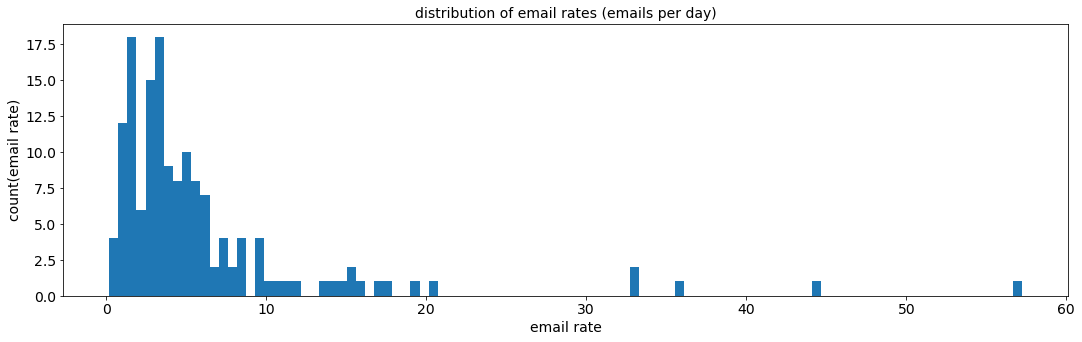

In [31]:
# also look at:
# words per day
# chars per day
# corr between words per email and num emails
# corr between words per email and avg. num recipients (to + cc + bcc, as a set)
display(tmp["email_rate"].agg(["min", "median", "max", "mean", "std"]))
plt.figure(figsize=(18, 5))
plt.hist(tmp["email_rate"], bins=100)
plt.title("distribution of email rates (emails per day)", fontsize=14)
plt.xlabel("email rate", fontsize=14)
plt.ylabel("count(email rate)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### From and To
The From and To metadata keys show who sent and who recveived an email.


In [32]:
# Sometimes From == TO
tmp = df_meta[(df_meta["From"] == df_meta["To"])]
print(f"Number where From == To: {len(tmp)}, {round(100.0 * len(tmp) / len(df_meta), 2)}%")
display(tmp)

Number where From == To: 16291, 3.15%


,Date,From,To,Subject,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Cc,user,path,fname,datetime_utc
1241,"Fri, 19 Oct 2001 06:11:32 -0700 (PDT)",bodyshop@enron.com,bodyshop@enron.com,FW: Security Smart ID Tags-Off Property Usage,text/plain; charset=us-ascii,7bit,Bodyshop </O=ENRON/OU=NA/CN=RECIPIENTS/CN=BODY...,Bodyshop </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Body...,,,"\PALLEN (Non-Privileged)\Allen, Phillip K.\Del...",Allen-P,PALLEN (Non-Privileged).pst,NaN,allen-p,deleted_items,107.,2001-10-19 13:11:32+00:00
1332,"Wed, 24 Oct 2001 18:39:57 -0700 (PDT)",members@realmoney.com,members@realmoney.com,Have you checked your credit rating lately?,text/plain; charset=us-ascii,7bit,<members@realmoney.com>@ENRON,members@realmoney.com <prod-special@pbulk01.th...,,,"\PALLEN (Non-Privileged)\Allen, Phillip K.\Del...",Allen-P,PALLEN (Non-Privileged).pst,NaN,allen-p,deleted_items,193.,2001-10-25 01:39:57+00:00
1347,"Thu, 25 Oct 2001 14:18:56 -0700 (PDT)",leanne@integrityrs.com,leanne@integrityrs.com,Single Tenant Properties,text/plain; charset=us-ascii,7bit,Leanne <leanne@integrityrs.com>@ENRON,leanne@integrityrs.com,,,"\PALLEN (Non-Privileged)\Allen, Phillip K.\Del...",Allen-P,PALLEN (Non-Privileged).pst,NaN,allen-p,deleted_items,207.,2001-10-25 21:18:56+00:00
1348,"Thu, 25 Oct 2001 12:33:44 -0700 (PDT)",members@realmoney.com,members@realmoney.com,Are you in the top 20?,text/plain; charset=us-ascii,7bit,<members@realmoney.com>@ENRON,members@realmoney.com <prod-special@pbulk01.th...,,,"\PALLEN (Non-Privileged)\Allen, Phillip K.\Del...",Allen-P,PALLEN (Non-Privileged).pst,NaN,allen-p,deleted_items,208.,2001-10-25 19:33:44+00:00
1407,"Mon, 29 Oct 2001 15:13:17 -0800 (PST)",leanne@integrityrs.com,leanne@integrityrs.com,MCE Educational Offering,text/plain; charset=us-ascii,7bit,Leanne <leanne@integrityrs.com>@ENRON,leanne@integrityrs.com,,,"\PALLEN (Non-Privileged)\Allen, Phillip K.\Del...",Allen-P,PALLEN (Non-Privileged).pst,NaN,allen-p,deleted_items,268.,2001-10-29 23:13:17+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515974,"Mon, 4 Feb 2002 03:00:42 -0800 (PST)",scoop@money.net,scoop@money.net,The Money.net Morning Scoop,text/plain; charset=ANSI_X3.4-1968,7bit,Good Morning from Money.net <scoop@money.net>,money.net Scoop Subscribers <scoop@money.net>,,,"\ExMerge - Zipper, Andy\Deleted Items",ZIPPER-A,andy zipper 6-26-02.PST,NaN,zipper-a,deleted_items,8.,2002-02-04 11:00:42+00:00
516139,"Fri, 8 Jun 2001 06:33:11 -0700 (PDT)",scoop@mailer.money.net,scoop@mailer.money.net,The Money.net Morning Scoop,text/plain; charset=ANSI_X3.4-1968,quoted-printable,"""Good Morning from Money.net"" <scoop@mailer.mo...",money.net Scoop Subscribers <scoop@mailer.mone...,,,"\Zipper, Andy\Zipper, Andy\Inbox",ZIPPER-A,"Zipper, Andy.pst",NaN,zipper-a,inbox,133.,2001-06-08 13:33:11+00:00
516226,"Wed, 21 Nov 2001 03:00:44 -0800 (PST)",scoop@mailer.money.net,scoop@mailer.money.net,The Money.net Morning Scoop,text/plain; charset=ANSI_X3.4-1968,7bit,Good Morning from Money.net <scoop@mailer.mone...,money.net Scoop Subscribers <scoop@mailer.mone...,,,"\AZIPPER (Non-Privileged)\Zipper, Andy\Inbox",Zipper-A,AZIPPER (Non-Privileged).pst,NaN,zipper-a,inbox,215.,2001-11-21 11:00:44+00:00
516231,"Tue, 5 Feb 2002 03:00:32 -0800 (PST)",scoop@money.net,scoop@money.net,The Money.net Morning Scoop,text/plain; charset=ANSI_X3.4-1968,7bit,Good Morning from Money.net <scoop@money.net>,money.net Scoop Subscribers <scoop@money.net>,,,"\ExMerge - Zipper, Andy\Inbox",ZIPPER-A,andy zipper 6-26-02.PST,NaN,zipper-a,inbox,22.,2002-02-05 11:00:32+00:00


In [33]:
# often, but not always, these have CC's
vc = tmp["X-cc"].value_counts()
# trim the Ccs to 80 chars, easier to view
vc.index = [i[:80] for i in vc.index]
display(vc)

                                                                                    6656
Meyers, Albert </O=ENRON/OU=NA/CN=RECIPIENTS/CN=BMEYERS>, Williams III, Bill </O    3106
bert.meyers@enron.com, bill.williams.III@enron.com, Craig.Dean@enron.com, dporte    2952
bert.meyers@enron.com, bill.williams.III@enron.com, Craig.Dean@enron.com, dporte    1167
bert.meyers@enron.com, bill.williams.III@enron.com, dporter3@enron.com, Geir.Sol     477
                                                                                    ... 
Angelika Staude <AStaude@iirltd.co.uk>                                                 1
Adams, Jacqueline P. </O=ENRON/OU=NA/CN=RECIPIENTS/CN=JADAMS2>, Reitmeyer, Jay <       1
'Daniel_Olson@kindermorgan.com', 'bmeckna@yahoo.com'                                   1
Hansen, Leslie </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Lhansen>                               1
foxylaura@surfmk.com                                                                   1
Name: X-cc, Length: 2

In [34]:
# Some Tos are missing
inds = df_meta["To"].isnull()
print(f"Number of missing \"To\" entries:            {inds.sum()}, {round(100.0 * inds.mean(), 2)}%")
# A few have Cc values even with no To values
inds = df_meta[["To", "Cc"]].isnull().all(axis=1)
print(f"Number of missing \"To\" and \"Cc\" entries:   {inds.sum()}, {round(100.0 * inds.mean(), 2)}%")
#display(df_meta.loc[inds, "Cc"].str.split(", ").apply(len).value_counts())


Number of missing "To" entries:            21846, 4.22%
Number of missing "To" and "Cc" entries:   20381, 3.94%


### Subject
The email subject can be examined in two ways:
- length of the subject (e.g. number of words, number of chars)
- the actual subject (e.g. what terms are used) 
<br><br>
A full analysis of the data could be used to find correlations between e.g. subject length and the time to get a response.

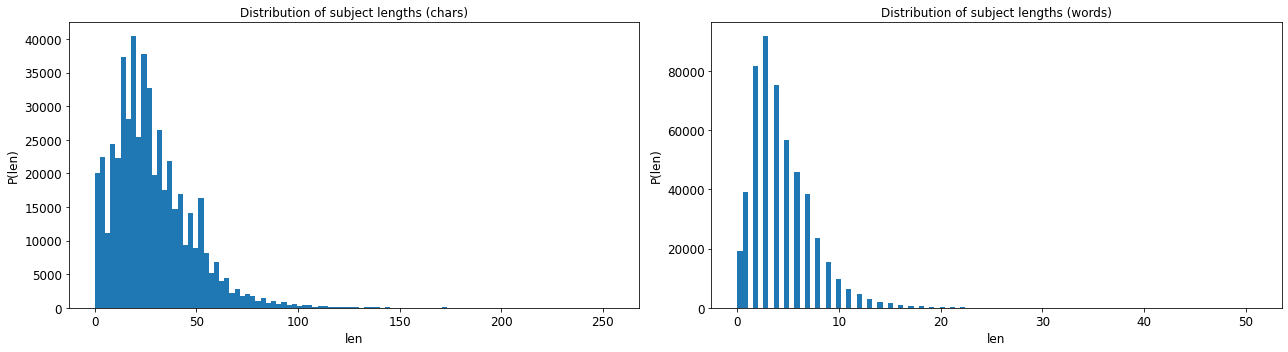

In [35]:
# The length in chars and words
subject_char_lens = df_meta["Subject"].fillna('').apply(len)
subject_word_lens = df_meta["Subject"].fillna('').str.split().apply(len)

plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.hist(subject_char_lens, bins=100)
plt.title("Distribution of subject lengths (chars)", fontsize=12)
plt.xlabel("len", fontsize=12)
plt.ylabel("P(len)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(subject_word_lens, bins=100)
plt.title("Distribution of subject lengths (words)", fontsize=12)
plt.xlabel("len", fontsize=12)
plt.ylabel("P(len)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [36]:
# Note: User, X-Origin and From are not the same thing
# Below shows, for each user, the number of unique X-Origin values, with some having 2+
df_meta.groupby("user")["X-Origin"].agg(["count", "nunique"])

,count,nunique
user,,
allen-p,3034,1
arnold-j,4898,2
arora-h,654,2
badeer-r,877,1
bailey-s,478,2
...,...,...
williams-w3,3440,2
wolfe-j,1587,2
ybarbo-p,1291,2


In [37]:
print(f"Unique X-Origin: {len(df_meta['X-Origin'].unique())}")
print(f"Unique X-From:   {len(df_meta['X-From'].unique())}")
print(f"Unique From:     {len(df_meta['From'].unique())}")
print(f"Unique user:     {len(df_meta['user'].unique())}")

# loop over each user, find those with more than 2 X-Origin values
# Some appear to be misspellings of the same name, others are mixed up
# Would need to check that the data is stored in the correct folder

for t in df_meta["user"].unique():
    vc = df_meta.loc[df_meta["user"] == t, "X-Origin"].str.lower().value_counts()
    if len(vc) > 1:
        print("\n")
        print("-" * 80)
        print(f"User: {t}")
        display(vc.to_frame())


Unique X-Origin: 259
Unique X-From:   27985
Unique From:     20328
Unique user:     150


--------------------------------------------------------------------------------
User: baughman-d


,X-Origin
baughman-e,1778
baughman-d,982




--------------------------------------------------------------------------------
User: dasovich-j


,X-Origin
dasovich-j,27786
shankman-j,448




--------------------------------------------------------------------------------
User: harris-s


,X-Origin
harris-s,472
kean-s,76




--------------------------------------------------------------------------------
User: kean-s


,X-Origin
kean-s,25261
harris-s,90




--------------------------------------------------------------------------------
User: king-j


,X-Origin
king-j,314
shankman-j,148




--------------------------------------------------------------------------------
User: lavorato-j


,X-Origin
lavorato-j,3445
lavorado-j,1240




--------------------------------------------------------------------------------
User: lucci-p


,X-Origin
lucci-p,724
luchi-p,273




--------------------------------------------------------------------------------
User: mims-thurston-p


,X-Origin
mims-thurston-p,1371
mims-p,667




--------------------------------------------------------------------------------
User: shankman-j


,X-Origin
shankman-j,3158
skilling-j,660
dasovich-j,38




--------------------------------------------------------------------------------
User: skilling-j


,X-Origin
skilling-j,3396
dasovich-j,676
king-j,67




--------------------------------------------------------------------------------
User: weldon-c


,X-Origin
wheldon-c,810
weldon-v,620
weldon-c,136




--------------------------------------------------------------------------------
User: whalley-l


,X-Origin
whalley-l,2364
whalley-g,971




--------------------------------------------------------------------------------
User: williams-w3


,X-Origin
williams-w3,2418
williams-b,1022




--------------------------------------------------------------------------------
User: zufferli-j


,X-Origin
zufferli-j,553
zufferlie-j,4


### Message bodies
The body of the message is read in as follows:
- take the lines in the email file below the final metadata line
- strip any html in the email
- merge the lines into a single string
- replace all whitespace with a single space
<br><br>
The messages may contain additional text, e.g. the message they are replying to (Original Message), or the message being forwarded (Forwarded Message). For now, we leave these in the messages.

In [38]:
start_time = time.time()

msgs_all = {}

# extract message bodies for a sample of N emails (use all or a sub-sample)
# Note: it can take ~50mins to read in all the messages (for ~500,000 emails)
N = len(df_meta)
if N < len(df_meta):
    inds = sorted(np.random.choice(range(len(df_meta)), N, replace=False))
else:
    inds = list(df_meta.index)

for i, ind in enumerate(inds):
    fname = os.path.join(data_path, "/".join(df_meta.loc[ind, ["user", "path", "fname"]].values))
    with open(fname, "r", errors='replace') as f:
        contents = f.readlines()
        try:
            msg = get_email_body(contents)
        except ValueError:
            print(f"{i}: No email body for {fname}")
            msg = ""
        msgs_all[ind] = msg
    if np.remainder((i + 1), int(N / 100)) == 0:
        print(f"complete: {round(100.0 * (i + 1) / N, 2)}% in {round(time.time() - start_time, 2)}s")
df_msgs = pd.DataFrame(msgs_all.values(), index=msgs_all.keys(), columns=["msg"])
print(time.time() - start_time)
display(df_msgs.sample(n=20))


/Users/matthew/tmp/feedstock/tmp/enron_emails/data_utils/data_extraction.py:81: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 81 of the file /Users/matthew/tmp/feedstock/tmp/enron_emails/data_utils/data_extraction.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(msg)


complete: 1.0% in 20.2s
complete: 2.0% in 40.43s
complete: 3.0% in 62.47s
complete: 4.0% in 81.19s
complete: 5.0% in 96.65s
complete: 6.0% in 111.39s
complete: 7.0% in 127.94s
complete: 8.0% in 145.13s
complete: 9.0% in 162.49s
complete: 10.0% in 180.41s
complete: 11.0% in 200.02s
complete: 12.0% in 221.27s
complete: 13.0% in 239.86s
complete: 14.0% in 261.49s
complete: 15.0% in 284.56s
complete: 16.0% in 302.34s
complete: 17.0% in 319.07s
complete: 18.0% in 335.17s
complete: 19.0% in 352.71s
complete: 20.0% in 368.02s
complete: 21.0% in 384.58s
complete: 22.0% in 399.81s
complete: 23.0% in 417.63s
complete: 24.0% in 433.08s
complete: 25.0% in 448.16s
complete: 26.0% in 463.45s
complete: 27.0% in 480.48s
complete: 28.0% in 499.04s
complete: 29.0% in 516.08s
complete: 30.0% in 533.27s
complete: 31.0% in 550.54s
complete: 32.0% in 566.93s
complete: 33.0% in 583.14s
complete: 34.0% in 602.93s
complete: 35.0% in 618.41s
complete: 36.0% in 633.33s
complete: 37.0% in 648.39s
complete: 38.0% 

,msg
258279,Louise's: Kevin Presto Dave Duran Tim Belden C...
361469,"I have reviewed the amendment to the Gty, but ..."
341613,please forward to everyone in our group. -----...
24928,change of time
326336,"Shanna, I'm supportive of the raise to $150k. ..."
98117,---------------------- Forwarded by Chris Dorl...
237210,Please see the attached memorandum.
60942,"If, at any time, it is necessary for anyone in..."
327262,Any update? How did the interview go? m
416746,Attached is the first report identifying finan...


In [56]:
if False:
    # save the messages (set to True to do so)
    df_msgs.to_csv(str(data_path.parent / "msgs.csv"))
if False:
    # read in the messages (set to True to do so)
    df_msgs = pd.read_csv(str(data_path.parent / "msgs.csv"), index_col=0)
    df_meta = pd.read_csv(str(data_path.parent / "meta.csv"), index_col=0)
    print(df_meta.shape, df_msgs.shape)

(517400, 17) (517400, 1)


In [57]:
# remove forwarded and original messages
if False:
    df_msgs["msg"] = df_msgs["msg"].str.split("----- Forwarded").str[0]
    df_msgs["msg"] = df_msgs["msg"].str.split("-----Original").str[0]

In [58]:
# remove missing messages (only had html)
inds_keep = df_msgs[df_msgs["msg"].notnull()].index
df_msgs = df_msgs.loc[inds_keep, :]
df_meta = df_meta.loc[inds_keep, :]
print(df_meta.shape, df_msgs.shape)

(517323, 17) (517323, 1)


In [59]:
# Some messages are duplicated (about 50%)
# These can be removed for the following analysis
f"Duplicated messages: {round(100.0 * df_msgs.duplicated().mean(), 2)}%"
df_meta = df_meta.loc[~df_msgs.duplicated(), :]
df_msgs = df_msgs.loc[~df_msgs.duplicated(), :]
print(df_meta.shape, df_msgs.shape)

(242984, 17) (242984, 1)


In [60]:
# data now read in and stored

### Text clustering
Below we implement an algorithm to cluster the data:
- Split the data into train, validation and test sets
- Fit a TF-IDF vectorizer to the train set
- Extract TF-IDF feature vectors for the train, val and test sets
- Fit a K-Means model to the train set, using the val set to find the optimal number of centers (using the Silhouette Score)
<br><br>

The Silhouette Score goes from -1 (bad fit) to +1 (good fit) and is the mean Silhouette Coefficient of all samples, which is given by `(b - a) / max(a, b)`, where
- a: the mean intra-cluster distance for each sample.
- b: the mean nearest-cluster distance for each sample. 
<br><br>

Once this model is fitted, we can use PCA to reduce the feature vectors to 2d and visualize the clusters.
<br><br>

The aim is to find patterns in the clusters, for e.g.:
- can we determine types of email (e.g. personal vs business, spam emails)
- can we find an interesting sub-set of emails to examine)

In [61]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, IncrementalPCA, NMF

from sklearn.metrics import silhouette_score

In [63]:
# split the data:
# fit to a random sub-sample of the dataset
# predict on a different sub-sample
inds = list(df_msgs.index)
np.random.shuffle(inds)

n_train = 50000
n_val = 10000
n_test = 10000

inds_train = inds[:n_train]
inds_val = inds[n_train : n_train + n_val]
inds_test = inds[n_train + n_val : n_train + n_val + n_test]

df_msgs_train = df_msgs.loc[inds_train, :].copy(deep=True)
df_msgs_test = df_msgs.loc[inds_test, :].copy(deep=True)
df_msgs_val = df_msgs.loc[inds_val, :].copy(deep=True)
del df_msgs

df_meta_train = df_meta.loc[inds_train, :].copy(deep=True)
df_meta_test = df_meta.loc[inds_test, :].copy(deep=True)
df_meta_val = df_meta.loc[inds_val, :].copy(deep=True)
del df_meta

In [66]:
# strip and stem the messages
df_msgs_train["msg_strip"] = strip_string(df_msgs_train["msg"].values.tolist())
df_msgs_val["msg_strip"] = strip_string(df_msgs_val["msg"].values.tolist())
df_msgs_test["msg_strip"] = strip_string(df_msgs_test["msg"].values.tolist())

# note, results are worse with stemming, so leave at this time
if False:
    df_msgs_train["msg_strip"] = stem_text(df_msgs_train["msg_strip"].values.tolist())
    df_msgs_val["msg_strip"] = stem_text(df_msgs_val["msg_strip"].values.tolist())
    df_msgs_test["msg_strip"] = stem_text(df_msgs_test["msg_strip"].values.tolist())

In [67]:
# remove named entities, replace with their type
# not used now due to speed issues.
if False:
    df_msgs_train["msg_strip"] = remove_named_entities(df_msgs_train["msg_strip"].values.tolist())
    df_msgs_val["msg_strip"] = remove_named_entities(df_msgs_val["msg_strip"].values.tolist())
    df_msgs_test["msg_strip"] = remove_named_entities(df_msgs_test["msg_strip"].values.tolist())


In [68]:
# fit the vectorizer to all the data, keep 10,000 features only due to memory constraints
vec = fit_tf_idf(
    msgs=df_msgs_train["msg_strip"].values.tolist(),
    max_features=10000,
    max_df=0.95,
    min_df=2
)

# get the features for the sample data
features_train = vec.transform(df_msgs_train["msg_strip"].values.tolist())
features_val = vec.transform(df_msgs_val["msg_strip"].values.tolist())

In [69]:
# leave the non-alpha terms / names / etc. in for now

# we could replace names (e.g. "glynn") with a placeholder (e.g. "PERSON"), although this
# operation is expensive and will be left for now

print(np.random.choice(list(vec.vocabulary_.keys()), 100, replace=False))
vocab = list(vec.vocabulary_.keys())

['thursday' 'overseeing' 'knows' 'travelling' 'aid' 'instance' 'arora'
 'acknowledges' 'shawn' 'brokers' 'levy' 'tolling' 'records' 'elektro'
 'fix' 'grace' 'informational' 'assets' 'jenny' 'crop' 'breaking'
 'indepth' 'tulsa' 'sweet' 'coke' 'makers' 'analytical' 'jan' 'sucks'
 'wires' 'destinataires' 'barnes' 'butler' 'counting' 'possible' 'clarify'
 'interconnects' 'bidders' 'bldg' 'extend' 'enter' 'mack' 'cst' 'trash'
 'hill' 'ally' 'recommend' 'purchsale' 'wheatley' 'hpl' 'attack' 'tse'
 'transparent' 'tracey' 'lynne' 'claimed' 'interviews' 'geoff' 'rising'
 'gillaspie' 'chris' 'bus' 'modifie' 'creating' 'tall' 'ken' 'securities'
 'leaf' 'mitigate' 'riordan' 'finalized' 'fallen' 'wisdom' 'conditional'
 'eds' 'naveen' 'allowing' 'stepped' 'requested' 'unusual' 'joannie'
 'convinced' 'worked' 'travelers' 'charged' 'developers' 'copper'
 'mounting' 'trustee' 'kill' 'defaulting' 'little' 'jeff' 'dvds' 'nc'
 'annual' 'von' 'murray' 'leather' 'wsccsw']


In [70]:
# loop through number of clusters, see which has lowest silhouette score

for n_clusters in [2, 3, 4, 5, 6, 7, 8]:
    cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
    cls.fit(features_train)
    # predict cluster labels for new dataset
    df_msgs_val[f"label_{n_clusters}"] = cls.predict(features_val)
    # to get cluster labels for the dataset used while
    # training the model (used for models that does not
    # support prediction on new dataset).
    vc = df_msgs_val[f"label_{n_clusters}"].value_counts()
    # get a sample for each label
    sample_size = min(vc.min(), int(8000 / n_clusters))
    if sample_size != 1:
        inds = []
        for i in vc.index:
            inds += list(df_msgs_val[df_msgs_val[f"label_{n_clusters}"] == i].sample(n=sample_size).index)
        inds = df_msgs_val.index.isin(inds)
        sil_score = silhouette_score(
                features_val[inds],
                labels=df_msgs_val[f"label_{n_clusters}"].values[inds]
            )
        print(n_clusters, sil_score, vc.to_dict())

2 0.12084489739080578 {0: 9810, 1: 190}
3 0.12002827016316678 {1: 8183, 2: 1672, 0: 145}
4 0.0658450723484589 {1: 6811, 3: 1735, 2: 1291, 0: 163}
5 0.03929321932525594 {1: 6740, 3: 1881, 0: 853, 2: 292, 4: 234}
6 0.018445621320157708 {3: 6010, 4: 1650, 2: 1475, 5: 698, 1: 126, 0: 41}
7 0.1369110622814847 {1: 5774, 3: 3068, 5: 551, 0: 207, 6: 173, 4: 122, 2: 105}
8 0.05482448374481985 {3: 5140, 5: 2020, 1: 1997, 0: 263, 6: 161, 2: 153, 4: 147, 7: 119}


- 2 and 3 and 7 both have roughly similar scores (we're using a small subsample of the data, so we'd expect large errors in these values).
- The analysis will continue with 3 clusters:
    - start with a small number, and increase later on

In [71]:
# will use 3, re-fit to the data
n_clusters = 3

cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
cls.fit(features_train)

# predict cluster labels for new dataset
features_test = vec.transform(df_msgs_test["msg_strip"].values.tolist())
df_msgs_test["label"] = cls.predict(features_test)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
vc = df_msgs_test["label"].value_counts()

sample_size = min(vc.min(), int(8000 / n_clusters))
if sample_size != 1:
    inds = []
    for i in vc.index:
        inds += list(df_msgs_test[df_msgs_test["label"] == i].sample(n=sample_size).index)
    inds = df_msgs_test.index.isin(inds)
    sil_score = silhouette_score(
            features_test[inds],
            labels=df_msgs_test["label"].values[inds]
        )
    print(n_clusters, sil_score, vc.to_dict())

3 0.1121195479735125 {1: 8237, 2: 1618, 0: 145}


In [72]:
# reduce the features to 2D using PCA
pca = PCA(n_components=2, random_state=0)
# use the incemental PCA for large datasets
#pca = IncrementalPCA(n_components=2, batch_size=1000)

# fit and transform
reduced_features = pca.fit_transform(features_test.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

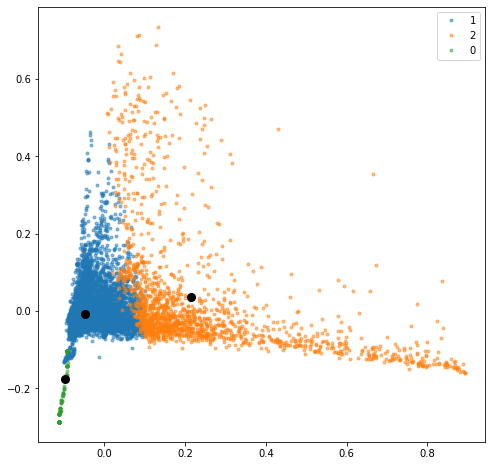

In [73]:
# plot the results
# cluster centers are plotted as black dots
plt.figure(figsize=(8, 8))
for i in df_msgs_test["label"].value_counts().index:
    inds = df_msgs_test["label"] == i
    plt.plot(
        reduced_features[inds, 0],
        reduced_features[inds, 1],
        marker="o",
        ms=3,
        linestyle="None",
        alpha=0.5,
        label=i)
plt.plot(
    reduced_cluster_centers[:, 0],
    reduced_cluster_centers[:, 1],
    marker='o',
    ms=8,
    linestyle="None",
    color="black"
)
plt.legend()
plt.show()

- The cluster centers are reasonably well separated
- Some overlap between them
<br>

We can now examine samples from within the clusters by:
- taking the samples that are closest to their cluster center.
- taking the samples that are furthest from (0, 0) for each predicted cluster.

In [74]:
# take the closest 10 results to each cluster center
closest = {}
for i in df_msgs_test["label"].value_counts().index:
    inds = df_msgs_test["label"] == i
    center = reduced_cluster_centers[i, :]
    # use L2 norm, sort by that distance
    dists = np.linalg.norm(reduced_features - center, axis=1)
    inds_sort = np.argsort(dists)
    # take the 10 closest
    closest[i] = list(df_msgs_test.iloc[inds_sort].loc[inds, :].index)[:10]

In [76]:
# view the messages,
for i, inds in closest.items():
    print("\n\n")
    print("=" * 50)
    print(i)
    print("=" * 50)
    print("\n\n".join(df_msgs_test.loc[inds, "msg_strip"].str[:400]))




1
 Now with your first purchase of casino chips at Grand Banks Cas ino youll get FREE Want your Free right now Get the so ftware at wwwgrandbankscasinocom Then use those chips to earn MORE fre e chips Because every time you make a bet at Grand Banks Casino well sa y thanks by giving you Rewards Points You can trade those points in for c ash in your pocket And youll start earning points from your ver

Original Message From Hartfield Rita Sent Thursday July PM To Reyna Margo Subject Changes at EBS Rita Hartfield Phone Cell Fax emailaddress Forwarded by Rita HartfieldEnron Communications on PM EBS Office of the Chairman Sent by EBS Announcements AM To EBS Worldwide cc Subject Changes at EBS To All EBS Employees Worldwide From EBS Office of the Chairman Subject Changes at EBS Date July Since its i

 Dorg men Theres been another liver lover added to the Homecoming listclass of brother Craig Shackleton Clickclickclickclickclick Bill Haack is trying to work things out so that he can make a

From a brief look at the emails, the clearest cluster is 0, which show some kind of automated emails.
- 0: Some kind of automated email?
- 1, 2: Seem to be the same?
<br>

Looking at the furthest form (0, 0) for each case, it looks like
- 1: to do with scheduling
- 2: business emails

In [77]:
# take the furthest 10 results from (0, 0) for each predicted cluster
furthest = {}
for i in df_msgs_test["label"].value_counts().index:
    inds = df_msgs_test["label"] == i
    # use L2 norm, sort by that distance
    dists = np.linalg.norm(reduced_features, axis=1)
    # take the 10 closest
    furthest[i] = list(df_msgs_test.iloc[inds_sort].loc[inds, :].index)[:10]

In [79]:
# view the messages
for i, inds in furthest.items():
    print("\n\n")
    print("=" * 50)
    print(i)
    print("=" * 50)
    print("\n\n".join(df_msgs_test.loc[inds, "msg_strip"].str[:500]))




1
CALENDAR ENTRY APPOINTMENT Description Weekly Priority MtgRaetta Date Time AM AM Central Standard Time Chairperson Outlook Migration Team Detailed Description

CALENDAR ENTRY APPOINTMENT Description Weekly Priority MtgRaetta Date Time AM AM Central Standard Time Chairperson Outlook Migration Team Detailed Description

CALENDAR ENTRY APPOINTMENT Description Weekly Priority MtgRaetta Date Time AM AM Central Standard Time Chairperson Outlook Migration Team Detailed Description

CALENDAR ENTRY APPOINTMENT Description meet w arun shiva Date Time AM AM Central Standard Time Chairperson Outlook Migration Team Detailed Description

CALENDAR ENTRY APPOINTMENT Description meet w Sally Date Time AM AM Central Standard Time Chairperson Outlook Migration Team Detailed Description

CALENDAR ENTRY APPOINTMENT Description TangieKN Imbalances Lynns Office Date Time AM AM Central Standard Time Chairperson Outlook Migration Team Detailed Description

CALENDAR ENTRY REMINDER Description Tom Chapmans 

In [80]:
# Where the emails came from and went to, by cluster
for i in df_msgs_test["label"].value_counts().index:
    print(i)
    # from
    vc_from = (
        df_meta_test.loc[df_msgs_test["label"] == i, "From"].fillna("@no_from").str.split("@").str[-1].value_counts(normalize=True)
    ).to_frame()
    # to
    vc_to = (
        df_meta_test.loc[df_msgs_test["label"] == i, "To"].fillna("@no_to").str.split("@").str[-1].value_counts(normalize=True)
    ).to_frame()
    # Cc
    all_cc = []
    for sub_list in (
        df_meta_test.loc[df_msgs_test["label"] == i, "Cc"].fillna("@no_cc").str.split(", ").apply(lambda x: [i.split("@")[-1] for i in x])
    ):
        all_cc += sub_list
    vc_cc = pd.Series(all_cc).value_counts(normalize=True).to_frame()
    vc_cc.columns = ["Cc"]
    # merge them
    vc_from = vc_from.merge(vc_to, left_index=True, right_index=True, how="outer").fillna(0)
    vc_from = vc_from.merge(
        vc_cc, left_index=True, right_index=True, how="outer"
    ).fillna(0).sort_values(["Cc", "From", "To"], ascending=False)
    display(vc_from)

1


,From,To,Cc
no_cc,0.000000,0.000000,0.503101
enron.com,0.740561,0.747481,0.392260
enron.com>,0.007406,0.009348,0.008321
haas.berkeley.edu,0.005220,0.006313,0.004239
aol.com,0.006799,0.012869,0.003846
...,...,...,...
whes.com,0.000000,0.000121,0.000000
worsham.net,0.000000,0.000121,0.000000
wulfe.com,0.000000,0.000121,0.000000
xtdl.com,0.000000,0.000121,0.000000


2


,From,To,Cc
enron.com,0.865884,0.782447,0.471865
no_cc,0.000000,0.000000,0.452740
haas.berkeley.edu,0.000000,0.000618,0.005149
yahoo.com,0.000000,0.003708,0.003310
paulhastings.com,0.003090,0.000000,0.002574
...,...,...,...
w-technologies.com,0.000000,0.000618,0.000000
weil.com,0.000000,0.000618,0.000000
wm.com,0.000000,0.000618,0.000000
wolfblock.com,0.000000,0.000618,0.000000


0


,From,To,Cc
enron.com,0.924138,0.917241,0.962128
no_cc,0.000000,0.000000,0.037872
enform.com,0.020690,0.000000,0.000000
eyeforenergy.com,0.013793,0.000000,0.000000
ix.netcom.com,0.006897,0.006897,0.000000
4quest.com,0.006897,0.000000,0.000000
akingump.com,0.006897,0.000000,0.000000
carpentersnodgrass.com,0.006897,0.000000,0.000000
enron.com>,0.006897,0.000000,0.000000
scientech.com,0.006897,0.000000,0.000000


Clusters 0 is mostly from Enron email address, clusters 1 and 2 have more external emails

### Topic analysis
In addition to the cluster analysis, we carry out a topic analysis. This uses Non-negative Matrix Factorization (NMF), where two non-negative matrices (W, H) are found whose product approximates the input feature matrix X (which is also non-negative, comprising an array of feature vectors for multiple samples).

- X: n_samples by n_features
- W: n_samples by n_components
- H: n_components by n_features

<br>

The procedure is carried out as follows:
- Extract nouns from the email messages. The topic is defined by the nouns in the message. (Note: this is slow, so we only use the val and test datasets.
- Fit a TF-IDF vectorizer to the val dataset.
- Use this to get feature arrays for the val and test datasets.
- Fit the NMF model to the val dataset, for a given number of components (we use 4, but could experiment with more/less: requries a scoring algoirthm to decide the best).
- Use this to get an idea of what groups of emails cover

In [84]:
# warning, slow!

#df_msgs_train["nouns"] = extract_message_nouns(df_msgs_train["msg"])
#print("train done")
df_msgs_val["nouns"] = extract_message_nouns(df_msgs_val["msg"])
print("val done")
df_msgs_test["nouns"] = extract_message_nouns(df_msgs_test["msg"])
print("test done")

val done
test done


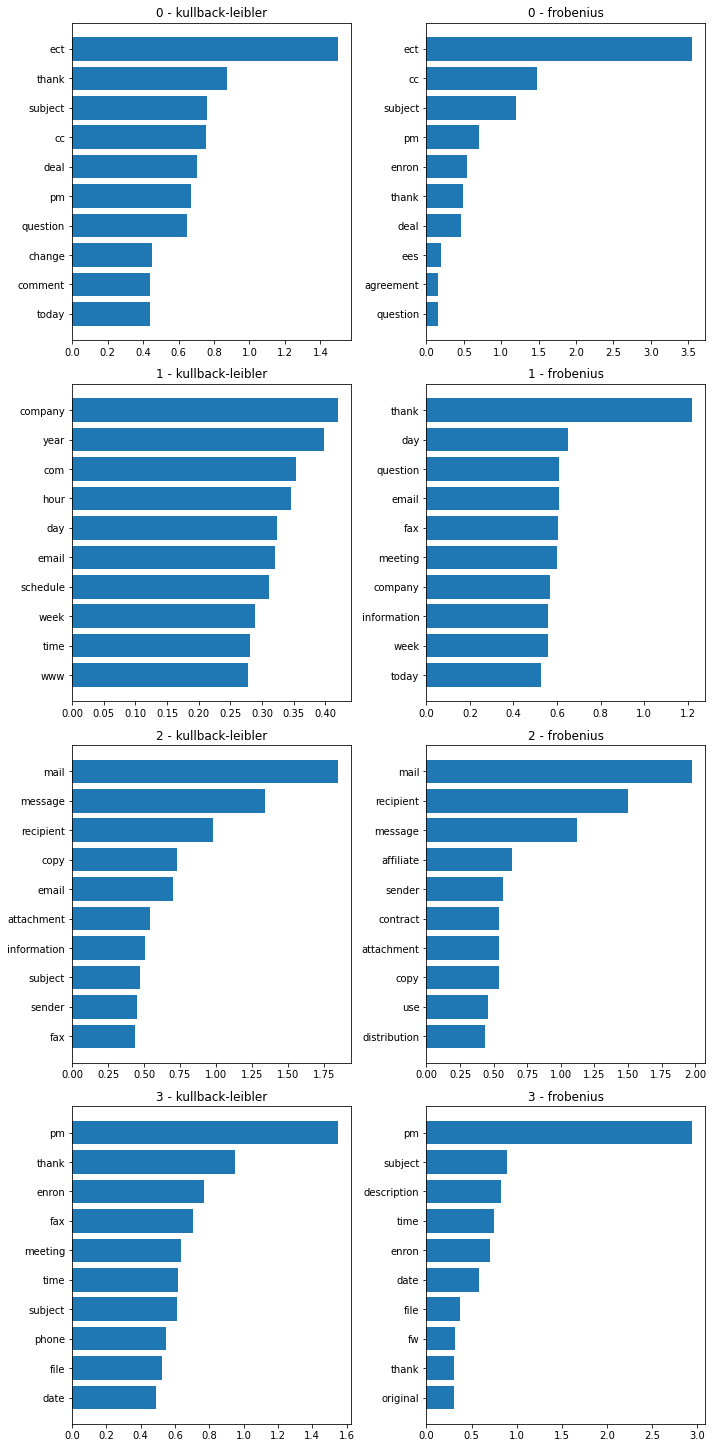

In [85]:
# number of topics to extract
n_topics = 4
# fit TF-IDF vectorizer to the train data
# use less features than before, as we only have nouns now
vec = TfidfVectorizer(max_features=5000, stop_words="english", max_df=0.95, min_df=2)
vec.fit(df_msgs_val["nouns"])

# list of unique words found by the vectorizer
feature_names = vec.get_feature_names()

# extract features for each set
#features_train = vec.transform(df_msgs_train["nouns"])
features_val = vec.transform(df_msgs_val["nouns"])
features_test = vec.transform(df_msgs_test["nouns"])


plt.figure(figsize=(10, 25))

for j, beta_loss in enumerate(["kullback-leibler", "frobenius"]):
    # git an NMF model the train data
    cls = NMF(n_components=n_topics, beta_loss=beta_loss, solver='mu', random_state=0)
    cls.fit(features_val)

    # number of most influencing words to display per topic
    n_top_words = 10
    
    for i, topic_vec in enumerate(cls.components_):
        plt.subplot(5, 2, 2 * i + 1 + j)
        inds = topic_vec.argsort()[:-n_top_words - 1:-1]
        plt.barh(np.array(feature_names)[inds][::-1], topic_vec[inds][::-1])
        plt.title(f"{i} - {beta_loss}")
plt.tight_layout()
plt.show()

- 0: ECT: Enron Capital and Trade Resources
- 1: business (e.g. price, market, company)
- 2: communication based (mail, message etc.)
- 3: thanking you + scheduling

In [86]:
nmf_labels_test = cls.transform(features_test)
nmf_labels_val = cls.transform(features_val)

In [91]:
# see how many are in each class

# Mostly business related class
# Least in communication class

vc = pd.Series(nmf_labels_test.argmax(axis=1)).value_counts().to_frame().reset_index().sort_values("index")
vc.columns = ["cluster", "count"]
ind_map = {
    0: "ECT",
    1: "business",
    2: "communication",
    3: "scheduling"
}

vc["label"] = vc["cluster"].map(ind_map)
display(vc)

,cluster,count,label
2,0,1249,ECT
0,1,6356,business
3,2,973,communication
1,3,1422,scheduling


### Conclusions from the data

- The dataset can be used to provide insights into employees email habits (e.g. rates, size of emails sent, when they are sent etc.). This assumes that the dataset is a representative sample of all emails sent by these users.
- The dataset requires cleaning before use (parsing the emails into metadata and body, dealing with missing/incorrect metadata etc.)
- An initial analysis of the messages shows clusters of topics, e.g. relating to scheduling meetings or to business information.

##### Further work
- The main improvement to this analysis would involve improved parsing of the email message bodies.
- The clustering used here could be used as the starting point to labelling the data:
    - label work and personal emails, to classify work emails for further analysis
    - label routine emails (e.g. automatic meeting reminders) and non-routine, so that routine emails can be removed from the dataset
- Reconstructing the email chain (i.e. find replies to emails) could be used to give insights into e.g. what types of messages elicit responses, what subjects are best etc.